In [38]:
!pip install kora -q
from kora import drive
drive.link_nbs()

In [41]:
import sys
sys.path.append('/content/drive/MyDrive/AI_Notebooks/SWIN')

In [8]:
!huggingface-cli login    # logging by token --> [token in my Notion]


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The token `token_feb_2025` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authen

#### 0) Loading & preparing data

In [5]:
!pip install datasets -q

In [24]:
import io
import torch
from torch import nn
from torch.utils.data import IterableDataset, DataLoader
from torchvision.datasets import ImageNet
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

In [10]:
from datasets import load_dataset
dset = load_dataset('imagenet-1k', split='train', streaming=True)

In [ ]:
# dataset + dataloader creation (ImageNet)

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    # why such values??
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageNet('.', split='train', transform=transform_train)
val_dataset = ImageNet('.', split='val', transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [29]:
# dset = load_dataset('imagenet-1k', split='train', streaming=True)

IMG_SIZE = 224                # Example image size - adjust as needed
MEAN = [0.485, 0.456, 0.406]  # Standard ImageNet mean
STD = [0.229, 0.224, 0.225]  # Standard ImageNet standard deviation

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor (C, H, W) with values between 0 and 1
    transforms.Normalize(mean=MEAN, std=STD)  # Normalize
])


def preprocess_image(image):
    """Preprocesses a single image given its bytes."""
    try:
        # image = Image.open(io.BytesIO(image_bytes))
        image = image.convert("RGB") if image.mode != "RGB" else image
        image = transform(image)
        return image
    except Exception as e:
        print(f"Error processing image: {e}")
        return None  # or return a default/dummy tensor


class ImageNetIterableDataset(IterableDataset):
    def __init__(self, dataset, preprocess_fn):
        self.dataset = dataset
        self.preprocess_fn = preprocess_fn

    def __iter__(self):
        for example in self.dataset:
            try:
                image = self.preprocess_fn(example['image'])
                if image is not None:
                    yield {"pixel_values": image, "labels": torch.tensor(example['label'])}
            except Exception as e:
                print(f"Error during iteration: {e}")
                continue

processed_dset = ImageNetIterableDataset(dset, preprocess_image)

BATCH_SIZE = 32

def collate_fn(examples):
    """Custom collate function for the IterableDataset."""
    examples = [ex for ex in examples if ex is not None]
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.stack([example["labels"] for example in examples])

    return {"pixel_values": pixel_values, "labels": labels}

dataloader = DataLoader(processed_dset, batch_size=BATCH_SIZE, collate_fn=collate_fn)


for epoch in range(1):
    for i, batch in enumerate(dataloader):
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]

        # pixel_values now contains a batch of preprocessed images as a tensor
        # labels contains the corresponding labels as a tensor

        # *** YOUR TRAINING CODE GOES HERE ***
        # Example: Print the shape of the pixel values and labels tensors
        print(f"Epoch: {epoch}, Batch: {i}")
        print(f"Pixel values shape: {pixel_values.shape}")  # Expected: [BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE]
        print(f"Labels shape: {labels.shape}")  # Expected: [BATCH_SIZE]

        # You would feed these tensors to your model for training
        # output = model(pixel_values)
        # loss = loss_function(output, labels)
        # ...

        if i > 5:  # Just process a few batches for demonstration
            break
    break  # Break after first epoch for demonstration

Epoch: 0, Batch: 0
Pixel values shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Epoch: 0, Batch: 1
Pixel values shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Epoch: 0, Batch: 2
Pixel values shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Epoch: 0, Batch: 3
Pixel values shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Epoch: 0, Batch: 4
Pixel values shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Epoch: 0, Batch: 5
Pixel values shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Epoch: 0, Batch: 6
Pixel values shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


In [ ]:
iter_dset = iter(processed_dset)

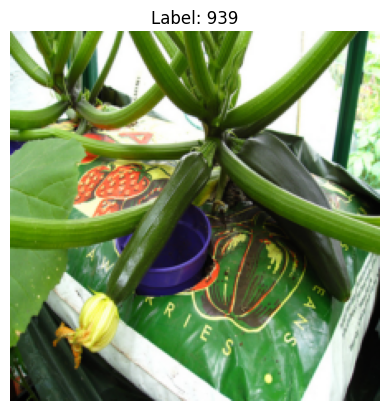

In [35]:
sample = next(iter_dset)

if sample is not None:
    image_tensor = sample["pixel_values"]
    # The image is normalized, so we need to unnormalize it for proper display.
    # However, here the transform contains no Normalization transform

    # reverse previously applied normalization:
    invTrans = transforms.Compose([
        transforms.Normalize(mean = [ 0., 0., 0. ],
                             std = [ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                             std = [ 1., 1., 1. ]),
        ])

    image_tensor = invTrans(image_tensor)

    image_tensor = image_tensor.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    image_np = image_tensor.numpy()  # Convert to numpy array

    plt.imshow(image_np)
    plt.title(f"Label: {sample['labels'].item()}") #Show label
    plt.axis('off')  # Hide the axis
    plt.show()
else:
    print("No image to display.")

In [42]:
from model import SwinTransformerBlock

In [45]:
# 2. Load ImageNet Class Names
#The class names file is available on the Hugging Face Hub
CLASS_NAMES_URL = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
import urllib.request, json
with urllib.request.urlopen(CLASS_NAMES_URL) as url:
    class_names = json.loads(url.read().decode())

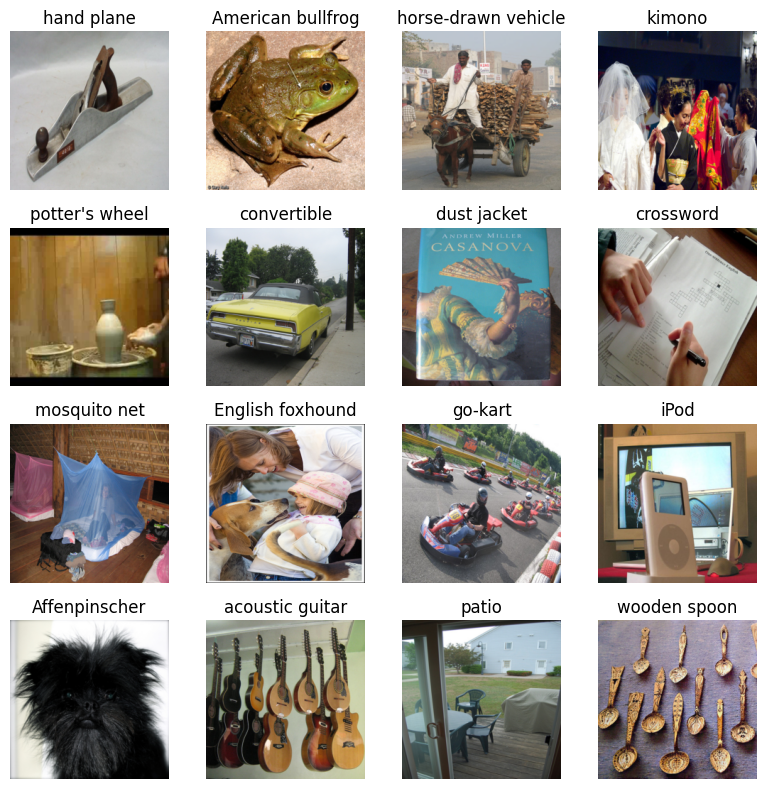

In [46]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))  # Create a 4x4 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

i = 0
for i, batch in enumerate(dataloader):
    image_tensor = batch["pixel_values"][0]  # Get the image tensor from the batch
    label = batch["labels"][0].item()  # Get the label
    class_name = class_names[label]

    # If you had normalization in your transform, you'd need to reverse it:
    invTrans = transforms.Compose([
        transforms.Normalize(mean = [ 0., 0., 0. ],
                             std = [ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                             std = [ 1., 1., 1. ]),
        ])
    image_tensor = invTrans(image_tensor)

    image_tensor = image_tensor.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    image_np = image_tensor.numpy()  # Convert to numpy array

    axes[i].imshow(image_np)
    axes[i].set_title(f"{class_name}")  # Set the title of the subplot
    axes[i].axis('off')  # Hide the axes
    i += 1
    if i >= 16: break

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()